# **Import the Necessary Libraries**

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from stable_baselines3 import PPO
import pandas as pd
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Load The Train and Test Sets**

In [2]:
"""

Input: The path to the train and test datasets.
Output: DataLoaders for the train and test datasets.
Functionality:
                - Loads the datasets from the specified paths.
                - Converts string representations of lists in the 'info_vector' and 'new_state' columns to actual lists.

"""

def process_data(file_path):
    df = pd.read_csv(file_path) # Load the dataset

    info_vector = [ast.literal_eval(item) for item in df['info_vector']] # Convert string representation of lists to actual lists
    new_state = [ast.literal_eval(item) for item in df['new_state']] # Convert string representation of lists to actual lists

    return info_vector, new_state

# <center>  **RL Simulations** </center>
### All the simulations were done using the [Gym framework](https://www.gymlibrary.dev/content/environment_creation)

## **Environment Definition**

In [3]:
class ContextualBanditEnv(gym.Env):
    def __init__(self, information_vector_list, new_state_list, range = (-1e6, 1e6)):
        super(ContextualBanditEnv, self).__init__()  # Ensure compatibility by calling the parent constructor

        self.info_vector_list = information_vector_list # Taking a duplicate of the information vector to avoid modifying the original one
        self.new_state_list = new_state_list # The new state is the information vector with the updated coordinates and velocity
        self.range = range # The range is used to define the observation space. It is set to (-1e6, 1e6) by default.
        self.indices = np.arange(len(self.info_vector_list)) # The indices are used to select the information vector from the list. It is set to the length of the information vector list by default.
        np.random.shuffle(self.indices) # The indices are shuffled to select a random information vector from the list.
        self.pointer = 0 # The pointer is used to select the information vector from the list. It is set to 0 by default.
        self.state = self._get_next_context() # The state is set to the first information vector from the list.
        assert len(information_vector_list) == len(new_state_list), "Mismatch between info_vector and new_state lists"

        ############################################################################################################################################################################

        # Observations are dictionaries with the state information. It has the coordinates of the trasmitting vehicle and the relative velocity between the transmitting and
        # receiving vehicles. The observation space is defined as a Box space with the specified range and shape.

        self.observation_space = spaces.Box(
                low = self.range[0],
                high = self.range[1],
                shape=(1, 5),
                dtype=np.float32
            )

        ############################################################################################################################################################################

        self.action_space = spaces.Discrete(2)  # 0: LOS, 1: NLOSv

    ################################################################################################################################################################################

    def reset(self, seed=None, **kwargs):
        super().reset(seed=seed)  # Proper Gym API use
        if seed is not None:
            np.random.seed(seed)

        # Return the observation and an empty info dict
        self.state = self._get_next_context()
        return self.state, {}

    def _get_next_context(self):

        if self.pointer >= len(self.info_vector_list):
            np.random.shuffle(self.indices)  # reshuffle once finished
            self.pointer = 0

        idx = self.indices[self.pointer]
        self.pointer += 1

        information_vector = self.info_vector_list[idx]
        self.new_state = self.new_state_list[idx]

        # Build the state from information_vector here
        state = [information_vector[0][0], information_vector[0][1],
                 information_vector[1][0], information_vector[1][1],
                 information_vector[2]]
        self.info_vector = information_vector  # save for reward_mechanism
        return state

    ################################################################################################################################################################################

    def reward_mechanism(self, action):

        predicted_channel_type = int(action)  # 0: LOS, 1: NLOSv
        reward = 0

        d = np.linalg.norm(np.array(self.new_state[0]) - np.array(self.new_state[1]))

        (a, b, c) = (2.1013e-6, -0.002, 1.0193)

        if d <= 475:
            prob_LOS = min(1, (a * d**2) + (b * d) + c)
        else:
            prob_LOS = max(0, 0.54 - 0.001 * (d - 475))

        if np.random.rand() < prob_LOS:
            if predicted_channel_type == 0:
                reward = 1
            else:
                reward = -1
        else:
            if predicted_channel_type == 1:
                reward = 1
            else:
                reward = -1

        return reward

    def step(self, action):
        reward = self.reward_mechanism(action)
        terminated = True
        truncated = False
        observation = self.state  # Return the current state as observation
        info = {}  # Add any relevant information here (e.g., additional metrics)
        return observation, reward, terminated, truncated, info

## **Dataset Loading**

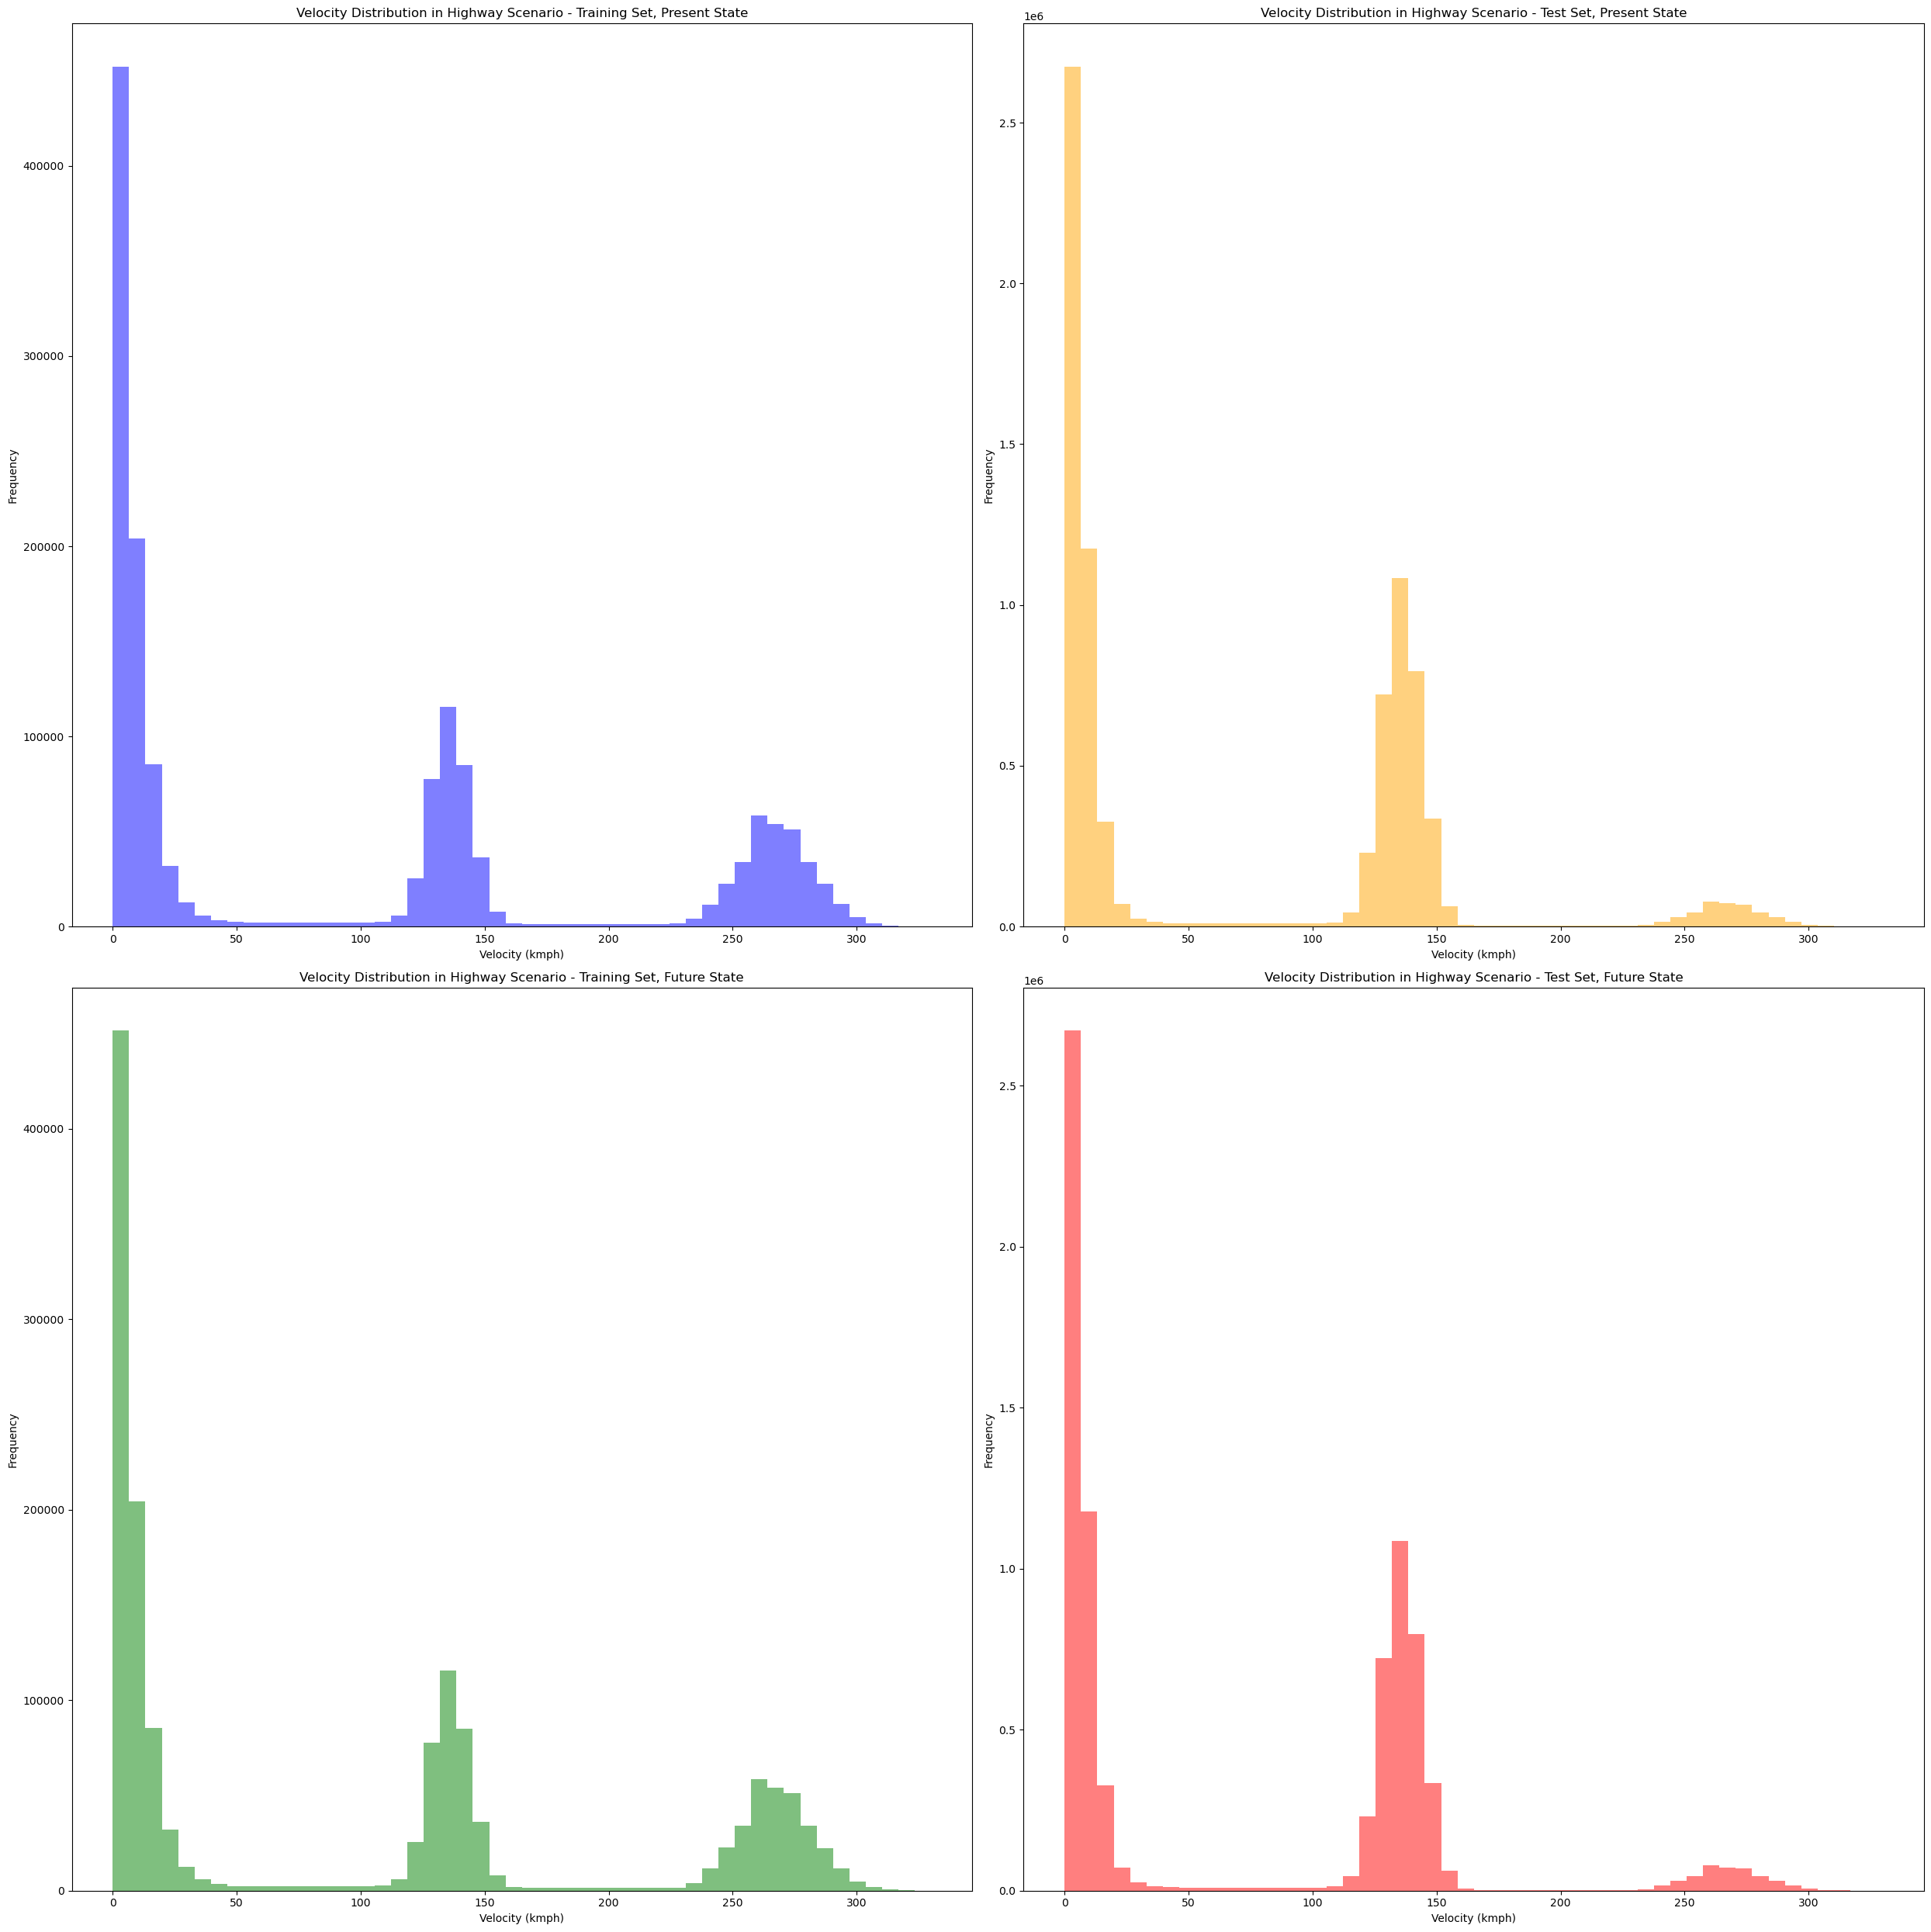

In [ ]:
# Path to the train and test datasets

train_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_highway_dataset.csv'
test_path = 'C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_highway_dataset.csv'

# Obtain the processed data for training and testing

final_info_vector, final_new_state = process_data(train_path)
final_info_vector_test, final_new_state_test = process_data(test_path)

# Velocity Statistics
velocity_train_present_state = [info[2] for info in final_info_vector]
velocity_test_present_state = [info[2] for info in final_info_vector_test]
velocity_train_future_state = [new_state[2] for new_state in final_new_state]
velocity_test_future_state = [new_state[2] for new_state in final_new_state_test]

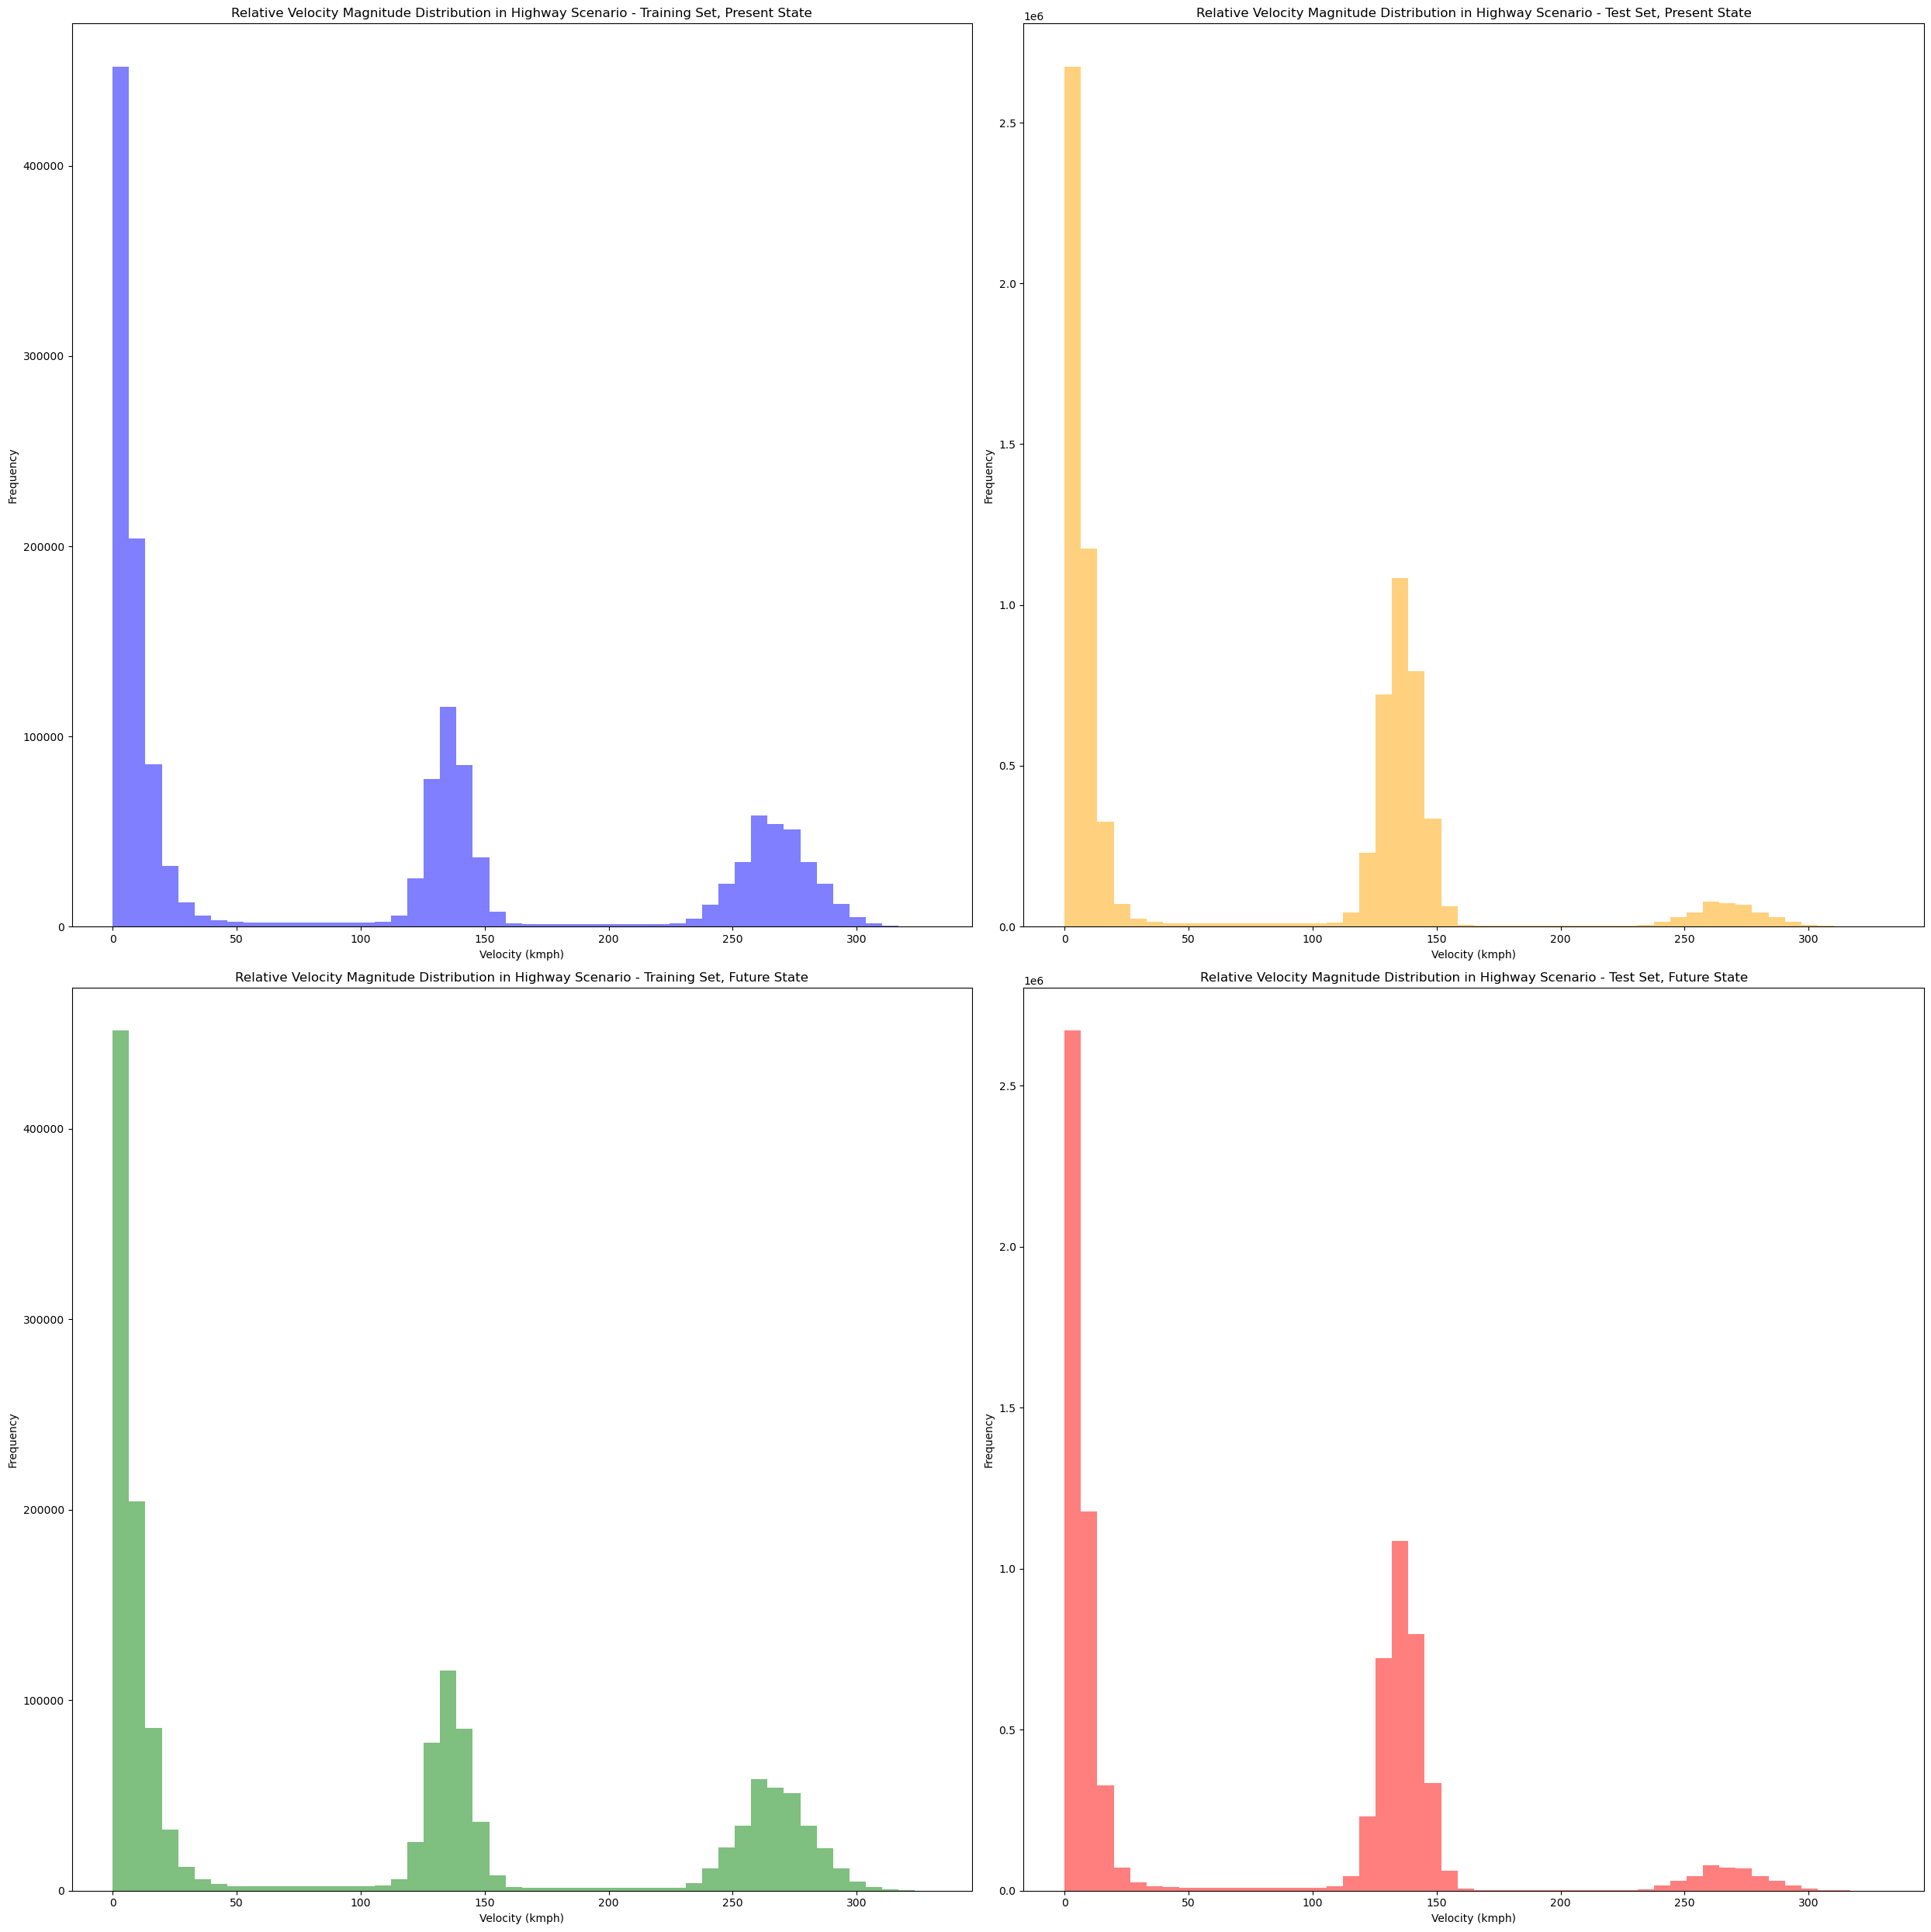

In [5]:
# Plot the velocity distributions

plt.figure(figsize=(25, 25))
plt.subplot(2, 2, 1)
plt.hist(velocity_train_present_state, bins=50, alpha=0.5, label='Train Present State Velocity', color='blue')
plt.title('Relative Velocity Magnitude Distribution in Highway Scenario - Training Set, Present State')
plt.xlabel('Velocity (kmph)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(velocity_test_present_state, bins=50, alpha=0.5, label='Test Present State Velocity', color='orange')
plt.title('Relative Velocity Magnitude Distribution in Highway Scenario - Test Set, Present State')
plt.xlabel('Velocity (kmph)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(velocity_train_future_state, bins=50, alpha=0.5, label='Train Future State Velocity', color='green')
plt.title('Relative Velocity Magnitude Distribution in Highway Scenario - Training Set, Future State')
plt.xlabel('Velocity (kmph)')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(velocity_test_future_state, bins=50, alpha=0.5, label='Test Future State Velocity', color='red')
plt.title('Relative Velocity Magnitude Distribution in Highway Scenario - Test Set, Future State')
plt.xlabel('Velocity (kmph)')
plt.ylabel('Frequency')
plt.tight_layout()  # Adjust layout to prevent overlap

# Save the plot as svg

plt.savefig('dataset_velocity_distribution_highway.pdf')
plt.show()

## **Training**

In [5]:
# Set up environment
env = ContextualBanditEnv(final_info_vector, final_new_state)

# Set up model
model = PPO('MlpPolicy', env,
            verbose = 0,
            learning_rate=5e-4,
            batch_size=1024,
            gamma=0.1,
            device = "cpu")

# Train with tqdm progress bar

model.learn(total_timesteps = 1500000, reset_num_timesteps = False, progress_bar = True)
model.save('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/Highway_Bandit_Classification_Updated')

Output()

# **Testing**

In [21]:
model = PPO.load('C:/Users/Vaideeswaran/Documents/ACS Project/Model Weights/Highway_Bandit_Classification_Updated', env = env)
expected_accuracy = 0
prob_LOS_list = []
prediction_list = []

for i in tqdm(range(len(final_info_vector_test))):
    # Build test context
    vec = final_info_vector_test[i]
    state = np.array([vec[0][0], vec[0][1], vec[1][0], vec[1][1], vec[2]]).reshape(1, -1)

    # Set state manually for logging
    env.state = state.tolist()[0]
    env.info_vector = vec
    action, _ = model.predict(state, deterministic=True) # Predict action
    prediction_list.append(int(action))  # Store the predicted action

    d = np.linalg.norm(np.array(final_new_state_test[i][0]) - np.array(final_new_state_test[i][1]))
    a = 2.1013e-6
    b = -0.002
    c = 1.0193

    if d <= 475:
        prob_LOS = min(1, (a * d**2) + (b * d) + c)
    else:
        prob_LOS = max(0, 0.54 - 0.001 * (d - 475))

    prob_LOS_list.append(prob_LOS)

    if action == 0:
        expected_accuracy = expected_accuracy + prob_LOS

    else:
        expected_accuracy = expected_accuracy + (1 - prob_LOS)

100%|██████████| 8113281/8113281 [1:38:56<00:00, 1366.69it/s]  


## **Performance Analysis**

In [22]:
expected_square_error = 0

for i in range(len(final_info_vector_test)):
    if prediction_list[i] == 0:
        expected_square_error += (prob_LOS_list[i] - 1) ** 2
    elif prediction_list[i] == 1:
        expected_square_error += (prob_LOS_list[i]) ** 2

print(f"Expected Square Error: {expected_square_error/ len(final_info_vector_test)}")
print(f"Average Accuracy: {expected_accuracy/ (len(final_info_vector_test))}")

Expected Square Error: 0.10586957144055553
Average Accuracy: 0.7095884949763427


In [23]:
accetable_prediction_count = 0
for i in range(len(final_info_vector_test)):
    if prediction_list[i] == 0 and prob_LOS_list[i] >= 0.5:
        accetable_prediction_count += 1
    elif prediction_list[i] == 1 and prob_LOS_list[i] < 0.5:
        accetable_prediction_count += 1

print(f"% of Acceptable Predictions: {accetable_prediction_count/ len(final_info_vector_test) * 100}%")

% of Acceptable Predictions: 96.30894085882147%


## **Save The Predictions**

In [24]:
# save the predictions and probabilities to a CSV file

predictions_df = pd.DataFrame({
    'prediction': prediction_list,
    'prob_LOS': prob_LOS_list
})
predictions_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Performance/Highway_Bandit_Classification_Performance.csv', index=False)